# Importando dados de Mercado do Desafio

In [1]:
import pandas as pd

url = 'C:\workspace\Desafio Grão Direto IA\Data\mercado-desafio.xlsx'

mercado = pd.read_excel(url)
mercado_dropna = mercado.dropna()
mercado_dropna.isnull().sum()

Date                 0
Company              0
Origin_city          0
Origin_state         0
Destination_city     0
Destination_state    0
Product              0
Price                0
CBOT                 0
dtype: int64

Recebendo a data minima e maxima

In [2]:
data_max = mercado_dropna.max()['Date']
data_max = str(data_max).replace(' 00:00:00','')
data_min = mercado_dropna.min()['Date']
data_min = str(data_min).replace(' 00:00:00','')
data_min

'2024-01-30'

Identificando outliers

<Axes: title={'center': 'Preço do Soja'}, xlabel='Data', ylabel='Preço'>

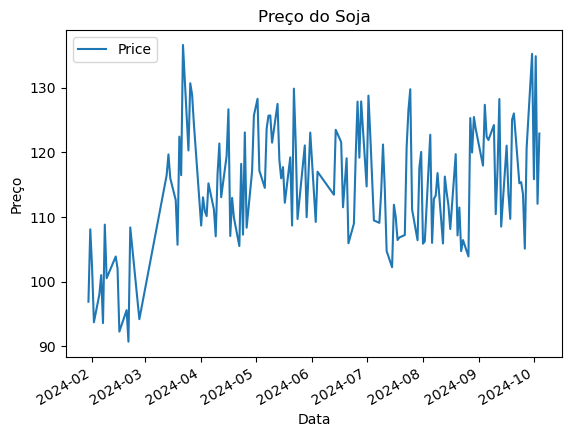

In [3]:
milho = mercado_dropna[mercado_dropna['Product'] == 'Milho']
soja = mercado_dropna[
    (mercado_dropna['Product'] == 'Soja') &
    (mercado_dropna['Origin_state'] == 'MG') &
    (mercado_dropna['Origin_city'] == 'Araguari') &
    (mercado_dropna['Destination_state'] == 'SP') &
    (mercado_dropna['Destination_city'] == 'Santos') &
    (mercado_dropna['Company'] == 'Polaris')
]
soja = soja.sort_values(by='Date', ascending=True)
soja.plot(x='Date', y='Price', kind='line', title='Preço do Soja', xlabel='Data', ylabel='Preço')

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fazendo cotação do Dolár

In [5]:
import yfinance as yf

dolar = yf.Ticker('USDBRL=X')
dolar_hist = dolar.history(interval='1d', start=data_min, end='2024-11-06')
dolar_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-30 00:00:00+00:00,4.950200,4.9773,4.933200,4.950200,0,0.0,0.0
2024-01-31 00:00:00+00:00,4.950300,4.9621,4.927000,4.950300,0,0.0,0.0
2024-02-01 00:00:00+00:00,4.951900,4.9664,4.912300,4.951900,0,0.0,0.0
2024-02-02 00:00:00+00:00,4.915000,4.9736,4.900782,4.915000,0,0.0,0.0
2024-02-05 00:00:00+00:00,4.932938,5.0147,4.932938,4.932938,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-30 00:00:00+00:00,5.760000,5.7885,5.672741,5.760000,0,0.0,0.0
2024-10-31 00:00:00+00:00,5.762300,5.7902,5.753358,5.762300,0,0.0,0.0
2024-11-01 00:00:00+00:00,5.789400,5.8318,5.760531,5.789400,0,0.0,0.0
